## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [2]:
!pip --disable-pip-version-check -q  install transformers
!pip --disable-pip-version-check -q install pyathena
!pip --disable-pip-version-check -q install torch==1.6.0

In [3]:
# General imports
import pandas as pd
import numpy as np
import collections

# nlp processing imports
import string
import re
import nltk
from transformers import DistilBertTokenizer


# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
from sagemaker import get_execution_role


# athena connection imports
from pyathena import connect
import boto3

import torch
from sagemaker.pytorch import PyTorch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

## Establishing Athena for SQL Queries

In [4]:
region = boto3.Session().region_name
role = get_execution_role()

In [5]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()
print(bucket)

sagemaker-us-east-1-492991381452


In [6]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [7]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [ ]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [8]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [9]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,6bFc8z35sk0,I Had A Mental Breakdown And Cut Awful Bangs,2021-03-16T18:31:39Z,UCR-QYzXrZF8yFarK8wZbHog,Colleen Ballinger,23,2021-03-20T00:00:00Z,colleen ballinger|colleen|ballinger|psychosopr...,615446,33500,1155,13367,https://i.ytimg.com/vi/6bFc8z35sk0/default.jpg,False,False,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,RoOZTKz0TsQ,The SEASON 6 BATTLEPASS is INSANE!! (100% UNLO...,2021-03-16T09:10:00Z,UCJAPcllL_VRxUiNKtaLOpzw,More SypherPK,20,2021-03-20T00:00:00Z,fortnite|fortnite battle royale|ninja|competit...,1056369,27700,1227,1854,https://i.ytimg.com/vi/RoOZTKz0TsQ/default.jpg,False,False,Today I react to the new Season 6 Battle Pass!...
4,bVnHisJl7Uc,Honest Trailers | WandaVision,2021-03-16T17:00:28Z,UCOpcACMWblDls9Z6GERVi1A,Screen Junkies,1,2021-03-20T00:00:00Z,screen junkies|fandom|honest trailers|screenju...,1012785,47974,813,3149,https://i.ytimg.com/vi/bVnHisJl7Uc/default.jpg,False,False,►►Subscribe to ScreenJunkies!► https://fandom....
5,AVIaZbvYAng,Ranboo bakes a cake [ANIMATION],2021-03-16T21:00:05Z,UCfUFXTeJlQsJUQHMR90nLHA,Kazoo Does Art,1,2021-03-20T00:00:00Z,kazoo|doesart|kazoodoesart|kazoo's art channel...,213984,36288,50,919,https://i.ytimg.com/vi/AVIaZbvYAng/default.jpg,False,False,Thank you all so much for watching!! This anim...
6,dsCjRjA4O7Y,The NEW Crisis in Cosmology,2021-03-16T20:15:01Z,UC7_gcs09iThXybpVgjHZ_7g,PBS Space Time,27,2021-03-20T00:00:00Z,Space|Outer Space|Physics|Astrophysics|Quantum...,545889,25332,484,2686,https://i.ytimg.com/vi/dsCjRjA4O7Y/default.jpg,False,False,https://www.patreon.com/pbsspacetimeI have goo...
7,RUJUAHYkBXM,DIY Upcycled Home Decor EXTREME CHALLENGE ft. ...,2021-03-16T18:00:25Z,UCtwzsvzRCfPddq2gPlgKW1w,Lone Fox,22,2021-03-20T00:00:00Z,Lone Fox Home|Drew Scott DIY|Imdrewscott DIY|D...,215781,15037,196,687,https://i.ytimg.com/vi/RUJUAHYkBXM/default.jpg,False,False,☆ Watch The Sorry Girls Video: https://www.you...
8,nNBDjJosK74,Post Malone - Hollywood's Bleeding (Live From ...,2021-03-15T17:41:25Z,UCOhtMAg7xh8wv_wUHMgFc-Q,PostMaloneVEVO,10,2021-03-20T00:00:00Z,Post Malone|post Malone grammys|post grammys|p...,2904235,157669,2196,8251,https://i.ytimg.com/vi/nNBDjJosK74/default.jpg,False,False,“Hollywood’s Bleeding” (Live From The 63rd GRA...
9,LALR0ovhVks,At Home With Kim Kardashian - The End of An Er...,2021-03-15T16:00:05Z,UCRXiA3h1no_PFkb1JCP0yMA,Vogue,24,2021-03-20T00:00:00Z,keeping up with the kardashians|kim kardashian...,2769262,87874,3163,5101,https://i.ytimg.com/vi/LALR0ovhVks/default.jpg,False,False,None


In [10]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [11]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,UJtjoQ5TcVI,T-Pain & Kehlani - I Like Dat (Official Video),2021-06-24T20:00:11Z,UCwff7OoSHp3el6GqnSwcSdA,T Pain,10,2021-06-27T00:00:00Z,[None],1732985,44140,337,2533,https://i.ytimg.com/vi/UJtjoQ5TcVI/default.jpg,False,False,Listen to the single I Like Dat. Out now!Strea...
1,dxK3ZO4Qd0w,Ski Mask The Slump God - ADMIT IT (Official Au...,2021-06-25T04:00:38Z,UCdARoxad2UaIQPDy6fbz4Nw,Ski Mask The Slump God,22,2021-06-27T00:00:00Z,ski mask|the slump god|skee mask|skimask|ski m...,479294,53958,384,4077,https://i.ytimg.com/vi/dxK3ZO4Qd0w/default.jpg,False,False,Ski Mask The Slump God Presents: “Sin City The...
2,131bSyhnng0,The Cummins Mustang Gets Twin Turbos off Semi ...,2021-06-25T00:01:22Z,UChRlaISXbl2gECFAmDzxgzg,Westen Champlin,2,2021-06-27T00:00:00Z,[None],665060,41755,346,2372,https://i.ytimg.com/vi/131bSyhnng0/default.jpg,False,False,The Cummins Mustang Gets Twin Turbos off Semi ...
3,EvKFGJamaj4,What's Inside this Giant Stressball from Vat19...,2021-06-25T13:00:07Z,UCa64Z5S3s3FqlLI1jnSXzAw,Vat19 Shorts,22,2021-06-27T00:00:00Z,vat19|vat19 shorts,296125,21247,772,120,https://i.ytimg.com/vi/EvKFGJamaj4/default.jpg,False,False,Shop Vat19: https://www.vat19.com?adid=ytshort...
4,6g2BKuflJ4g,"Simone Biles nails double double dismount, wow...",2021-06-26T02:23:25Z,UCqZQlzSHbVJrwrn5XvzrzcA,NBC Sports,17,2021-06-27T00:00:00Z,Olympic Sports|Olympics|simone biles|gymnastic...,1560497,9619,207,931,https://i.ytimg.com/vi/6g2BKuflJ4g/default.jpg,False,False,Simone Biles did her thing on beam during Day ...
5,qFCeCPpfnhQ,WHY did I get my hopes up? - Windows 11 Announ...,2021-06-25T06:21:34Z,UCXuqSBlHAE6Xw-yeJA0Tunw,Linus Tech Tips,28,2021-06-27T00:00:00Z,microsoft|windows|windows 11|11|operating syst...,2510442,122605,2339,18178,https://i.ytimg.com/vi/qFCeCPpfnhQ/default.jpg,False,False,Get a Free Pair of Wireless Bluetooth Headphon...
6,mxG5UfyIYTk,Chase Atlantic - OHMAMI (Official Lyric Video),2021-06-25T04:00:11Z,UCpvCJWgUNwZArGtJ00kDS1A,CHASE ATLANTIC,10,2021-06-27T00:00:00Z,chase atlantic|ohmami|oh mami|chase atlantic o...,1167199,209347,715,21114,https://i.ytimg.com/vi/mxG5UfyIYTk/default.jpg,False,False,CHASE ATLANTIC – OHMAMIListen/Download single:...
7,kmk5vciFbek,Demi Lovato performs their greatest hits this ...,2021-06-26T00:07:19Z,UCZkURf9tDolFOeuw_4RD7XQ,Demi Lovato,24,2021-06-27T00:00:00Z,Pride|Pride 2021|YouTube Pride|YouTube Pride 2...,0,0,0,138,https://i.ytimg.com/vi/kmk5vciFbek/default.jpg,False,True,"On June 25, celebrate Pride 2021 with Demi Lov..."
8,rGKhjmSTYgE,NEW DRUGSTORE MAKEUP TESTED ... What's Good?,2021-06-24T19:00:09Z,UC4qk9TtGhBKCkoWz5qGJcGg,Tati,26,2021-06-27T00:00:00Z,YouTube|Beauty|Makeup|Tutorial|Review|blogger|...,907083,76893,816,7454,https://i.ytimg.com/vi/rGKhjmSTYgE/default.jpg,False,False,I'm going a throwback of What's New at The Dru...
9,U2chMEBdaCU,"Pancho Barraza & Grupo Firme, Eduin Caz - Mús...",2021-06-24T22:00:11Z,UC182E6DfqeGhPcyo-6N8xig,Pancho Barraza Oficial,10,2021-06-27T00:00:00Z,grupo firme|pancho barraza|banda ms|musica rom...,817118,30115,447,1084,https://i.ytimg.com/vi/U2chMEBdaCU/default.jpg,False,False,Titulo: Musica Romantica (Video Oficial)https:...


In [12]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [13]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,lMBXncqJYV0,Euro 2020: Italian team returns home after tou...,2021-07-12T05:44:28Z,UC86dbj-lbDks_hZ5gRKL49Q,AFP News Agency,25,2021-07-14T00:00:00Z,1ST|IMAGES|FBL|EURO|2020|2021|AFP|NEWS|ACTU|INFO,1103798,18370,405,1929,https://i.ytimg.com/vi/lMBXncqJYV0/default.jpg,False,False,"The Italian Euro 2020 team arrives in Rome, st..."
1,SBIKp51Qhs0,Finally Asking Nailea about Vinnie Hacker | Di...,2021-07-11T17:00:10Z,UCLOEGprmycLLbyzBj2jozLg,Dixie D'Amelio,22,2021-07-14T00:00:00Z,Dixie D'Amelio|The Early Late Night Show|Naile...,932015,58047,1307,2432,https://i.ytimg.com/vi/SBIKp51Qhs0/default.jpg,False,False,Hi everyone! Welcome back to another episode o...
2,f9mdVVXPHgQ,US vs UK Jollibee | Food Wars,2021-07-11T16:00:26Z,UCwiTOchWeKjrJZw7S1H__1g,Food Insider,19,2021-07-14T00:00:00Z,INSIDER|FOOD INSIDER|Food Wars|Jolibee|Fried C...,419735,13313,137,1679,https://i.ytimg.com/vi/f9mdVVXPHgQ/default.jpg,False,False,"From calorie count to portion sizes, we ordere..."
3,kic4V8eP_iQ,"Mini Trip to London, Haul & Getting Outside",2021-07-10T18:52:11Z,UCrUbqTCagwsaP2Fmr0p1TsA,Zoe Sugg,22,2021-07-14T00:00:00Z,Zoe Sugg|vlog|Zoella|makeup|grwm|get ready wit...,548423,22944,224,320,https://i.ytimg.com/vi/kic4V8eP_iQ/default.jpg,False,False,"Mini Trip to London, Haul & Getting OutsideLin..."
4,lGI_zSBJKfg,"CHUNKZ, FILLY AND JACK EAT BAMBINO BECKYS JERK...",2021-07-10T18:00:10Z,UCSTJELgD0j0gW2_wgF_TYuA,Footasylum,24,2021-07-14T00:00:00Z,chunkz|nella rose|footasylum|does the shoe fit...,611808,25177,126,670,https://i.ytimg.com/vi/lGI_zSBJKfg/default.jpg,False,False,https://www.footasylum.com/ Subscribe if you’r...
5,ZX5dR63n7jo,FIRST FIFA 22 REVEAL! | CREATE A CLUB CAREER M...,2021-07-11T18:15:27Z,UC5Qb_4X2CkAnvacIj94Xxzw,MGH,20,2021-07-14T00:00:00Z,FIFA|Gameplay|Career Mode|Ultimate Team|Pro Cl...,74307,2983,80,454,https://i.ytimg.com/vi/ZX5dR63n7jo/default.jpg,False,False,WATCH ME LIVE! http://www.fb.gg/mghfbJoin my D...
6,jSIdllridsg,Richard Branson reaches edge of space on Virgi...,2021-07-11T17:11:08Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,25,2021-07-14T00:00:00Z,Bottom Line|CNBC|business news|finance stock|s...,355801,3478,296,1119,https://i.ytimg.com/vi/jSIdllridsg/default.jpg,False,False,"Sir Richard Branson, after nearly 17 years of ..."
7,SAwlqiXD2aw,Disappointed fans leave Wembley following Euros,2021-07-12T02:21:17Z,UCnQvCx33v1mrgleEwVH4DxA,MrBeanyman,17,2021-07-14T00:00:00Z,Football|Soccer|Beanyman|BeanymanSports|Beany|...,104357,891,32,788,https://i.ytimg.com/vi/SAwlqiXD2aw/default.jpg,False,False,Tens of thousands of dejected England fans hav...
8,oFqVvjq6BGM,Dave - Clash (ft. Stormzy),2021-07-09T11:20:45Z,UC5-cg5RahETrjGu-r8zjYCQ,Santan Dave,10,2021-07-14T00:00:00Z,[None],3317477,148824,2616,8503,https://i.ytimg.com/vi/oFqVvjq6BGM/default.jpg,False,False,Stream Clash: https://santandave.lnk.to/ClashF...
9,XeuXShFIgyc,Why Millions Buy Harley-Davidson Motorcycles,2021-07-11T15:00:13Z,UCNSMdQtn1SuFzCZjfK2C7dQ,FortNine,2,2021-07-14T00:00:00Z,[None],542191,37219,462,4254,https://i.ytimg.com/vi/XeuXShFIgyc/default.jpg,False,False,None


#### JSON Tables

In [14]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://{bucket}/youtubeStatistics/json/usa/US_category_id_test.json';
"""

pd.read_sql(us_json_create, conn)

""


In [15]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


In [9]:
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,default
1,youtubedb
2,youtubestatistics


In [10]:
if db_name in db_show.values:
    ingest_create_athena_db_passed = True

In [11]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Exploratory Data Analysis

#### US Gaming Exploration

Preparing the data for exploration by adjusting the necessary column types.

### Initial Preprocesssing and transformations to visualize the data properly

#### Data Import 

The data set below is created from the United States area where categoryid = 20 or 'Gaming' category on Youtube. As many of the creators under our companies umbrella do create 'Gaming' content, it is a key area for ViewBoost to focus in on. It also provides an opportunity to refine a robust deep learning neural network as there is still 37,000 records within the US Gaming segment. 

In [8]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,qcY9qy1SaL8,"I Survived 2,000 Days in HARDCORE Minecraft...",2021-10-23T12:15:11Z,UCFrVj6wBM42y3XuKCAj8n5A,SB737,20,2021-10-27T00:00:00Z,minecraft|gaming|sb737|sb minecraft|sb|let's p...,2163189,123429,1683,8435,https://i.ytimg.com/vi/qcY9qy1SaL8/default.jpg,False,False,"BUY 2,000 DAYS POSTER HERE: https://sb737.stor..."
1,8kVXGfKIk9I,I made a minecraft mod EVERY DAY for 100 DAYS,2021-10-23T19:00:13Z,UCfGkyZGTurOs8Xrylyu4G2Q,Its Jim,20,2021-10-27T00:00:00Z,techonoblade|minecraft|fundy|wilbur soot|tommy...,773055,16321,436,859,https://i.ytimg.com/vi/8kVXGfKIk9I/default.jpg,False,False,I added a mod every day to my Minecraft hardco...
2,1ruCFtzohh8,Chapter 1 Fortnite is Back!,2021-10-24T13:35:47Z,UCh7EqOZt7EvO2osuKbIlpGg,Lachlan,20,2021-10-27T00:00:00Z,lachlan lachy fortnite battle royale pubg batt...,864778,50238,532,1588,https://i.ytimg.com/vi/1ruCFtzohh8/default.jpg,False,False,Today we go back to OG Fortnite with a fun tou...
3,uWSUnZ_exoM,I Stole my Friends Among Us Statue,2021-10-23T14:00:32Z,UCvt0HYxX34vUvqu66HLXeUw,rekrap2,20,2021-10-27T00:00:00Z,rekrap2|rekrap|rek|Echocraft|Boatclutch,659838,20315,358,1242,https://i.ytimg.com/vi/uWSUnZ_exoM/default.jpg,False,False,"I stole my Friends Among Us statue, and it sta..."
4,3437syY-2P0,"Minecraft Manhunt, But Clutching Gives OP Item...",2021-10-24T00:01:02Z,UCWWcJg7XWc5erpRJJtO1mgw,P0LAND,20,2021-10-27T00:00:00Z,Minecraft|Challenge|Minecraft Challenge|Minecr...,445194,16732,310,856,https://i.ytimg.com/vi/3437syY-2P0/default.jpg,False,False,"Minecraft Manhunt, But Clutching Gives OP Item..."


##### Data type transformations

In [9]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print("Initial data types:", us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)

# Change to bool then int representations
us_gaming['ratings_disabled'] = us_gaming['ratings_disabled'].astype(bool).apply(int)
us_gaming['comments_disabled'] = us_gaming['comments_disabled'].astype(bool).apply(int)

# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)
print(us_gaming.isnull().sum())
print("New data types:", us_gaming.dtypes)
us_gaming.head()

Length of data frame: 37071
Width of data frame: 16
Initial data types: video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object
video_id                0
title                   0
publishedat             0
channelid               0
channeltitle            0
categoryid              0
trending                0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          1296
dtype: int64
New data types: video_id             

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,qcY9qy1SaL8,"I Survived 2,000 Days in HARDCORE Minecraft...",2021-10-23 12:15:11,UCFrVj6wBM42y3XuKCAj8n5A,SB737,20,2021-10-27,minecraft|gaming|sb737|sb minecraft|sb|let's p...,2163189,123429,1683,8435,https://i.ytimg.com/vi/qcY9qy1SaL8/default.jpg,1,1,"BUY 2,000 DAYS POSTER HERE: https://sb737.stor..."
1,8kVXGfKIk9I,I made a minecraft mod EVERY DAY for 100 DAYS,2021-10-23 19:00:13,UCfGkyZGTurOs8Xrylyu4G2Q,Its Jim,20,2021-10-27,techonoblade|minecraft|fundy|wilbur soot|tommy...,773055,16321,436,859,https://i.ytimg.com/vi/8kVXGfKIk9I/default.jpg,1,1,I added a mod every day to my Minecraft hardco...
2,1ruCFtzohh8,Chapter 1 Fortnite is Back!,2021-10-24 13:35:47,UCh7EqOZt7EvO2osuKbIlpGg,Lachlan,20,2021-10-27,lachlan lachy fortnite battle royale pubg batt...,864778,50238,532,1588,https://i.ytimg.com/vi/1ruCFtzohh8/default.jpg,1,1,Today we go back to OG Fortnite with a fun tou...
3,uWSUnZ_exoM,I Stole my Friends Among Us Statue,2021-10-23 14:00:32,UCvt0HYxX34vUvqu66HLXeUw,rekrap2,20,2021-10-27,rekrap2|rekrap|rek|Echocraft|Boatclutch,659838,20315,358,1242,https://i.ytimg.com/vi/uWSUnZ_exoM/default.jpg,1,1,"I stole my Friends Among Us statue, and it sta..."
4,3437syY-2P0,"Minecraft Manhunt, But Clutching Gives OP Item...",2021-10-24 00:01:02,UCWWcJg7XWc5erpRJJtO1mgw,P0LAND,20,2021-10-27,Minecraft|Challenge|Minecraft Challenge|Minecr...,445194,16732,310,856,https://i.ytimg.com/vi/3437syY-2P0/default.jpg,1,1,"Minecraft Manhunt, But Clutching Gives OP Item..."


Above lists the new data types in addition to listing the null values. For our dataset the only null values exist in the description column as many of the videos simply have not had a description written, these values are still important for the dataset and should not be dropped. Instead, the null descriptions will be filled with "Not Available" as a way to give the nulls a stand-in value.

##### Null Handling

Null values are important within this dataset and will therefore have words assigned to them for representation. 

In [10]:
us_gaming['description'].fillna("not available", inplace = True)
us_gaming.isna().sum()

video_id             0
title                0
publishedat          0
channelid            0
channeltitle         0
categoryid           0
trending             0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
dtype: int64

The value counts of the binary features below show that both have zero distribution and should not be used in modeling moving forward. 

In [11]:
print(us_gaming['ratings_disabled'].value_counts())
print(us_gaming['comments_disabled'].value_counts())

1    37071
Name: ratings_disabled, dtype: int64
1    37071
Name: comments_disabled, dtype: int64


In [12]:
us_gaming.drop(columns = ['ratings_disabled', 'comments_disabled', 'thumbnail_link'], inplace = True)

us_gaming.shape

(37071, 13)

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create visualizations based up the vocabulary available within the dataset. 

In [34]:
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

In [35]:
tag = train['tags']
title = train['title']
description = train['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)
#descriptions = vecdes.fit_transform(description)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)
#print(descriptions.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(29656, 11501)
(29656, 6065)


### Creating Visualizations

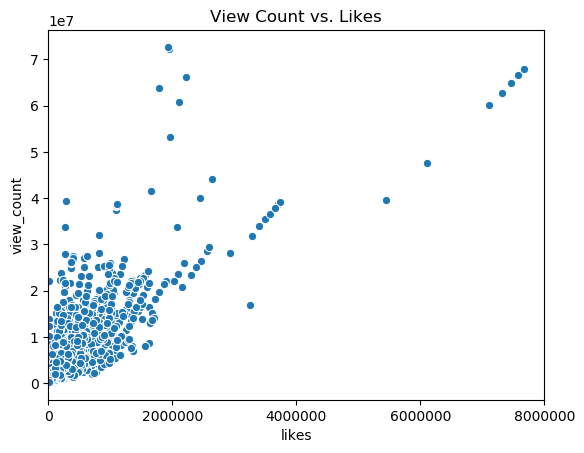

In [30]:
fig, ax = plt.subplots()

sns.scatterplot(data = us_gaming, x = "likes", y = "view_count", ax = ax)
plt.title("View Count vs. Likes")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

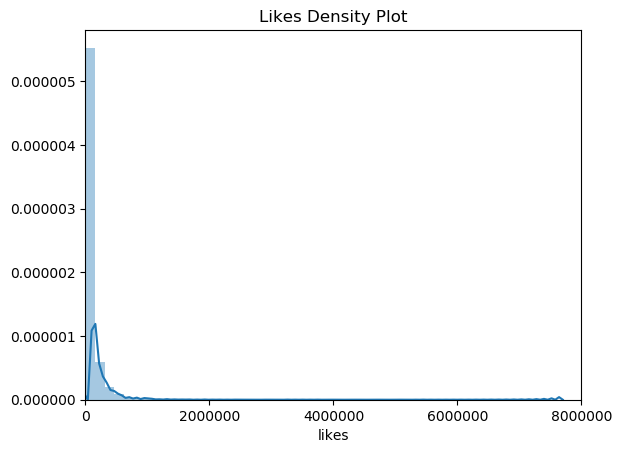

In [31]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

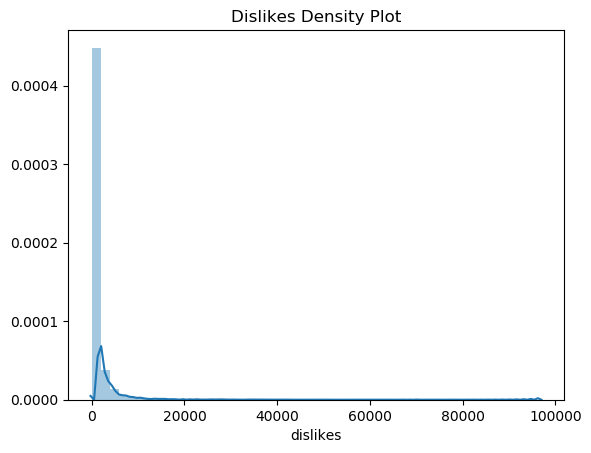

In [32]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

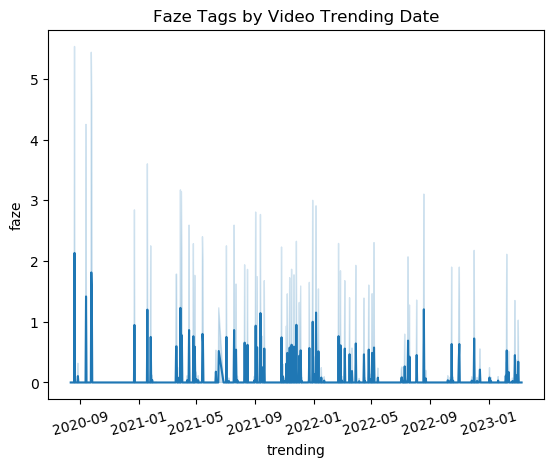

In [39]:
sns.lineplot(x = us_gaming["trending"], y = tag_df["faze"])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

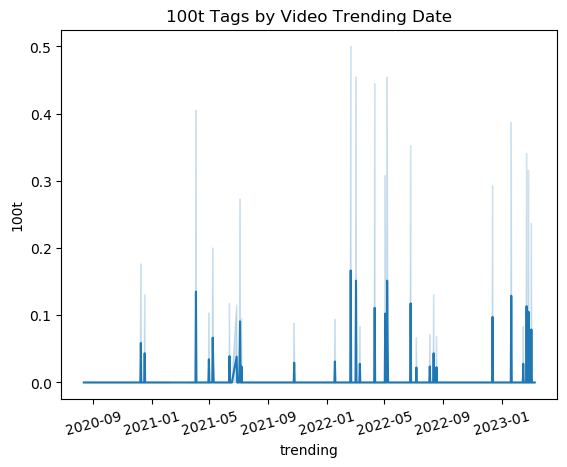

In [40]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['100t'])
plt.xticks(rotation = 15)
plt.title("100t Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

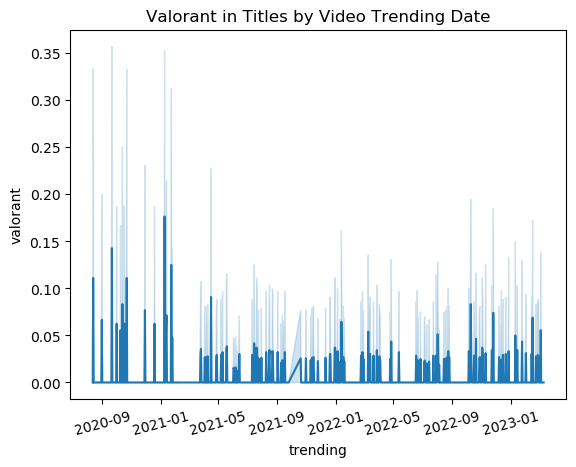

In [41]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

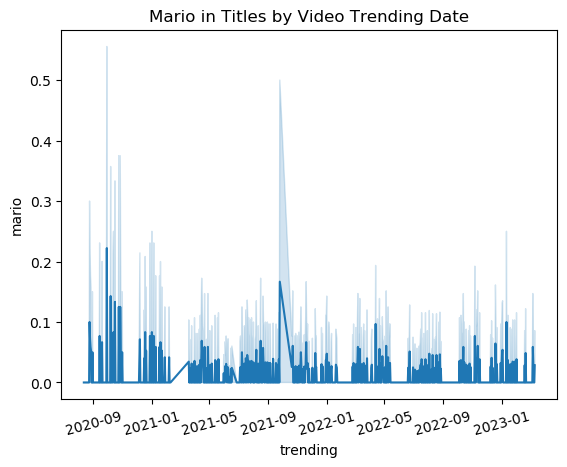

In [42]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()

### Feature Selection Final Decisions

Ultimately, as the goal of the project is to predict views, dislikes, likes, comment count, posting date, trending date, channelid, channel title, and thumbnail link cannot be used as predictors because we hope to predict the view count of the video before the video is posted. Perhaps in future projects an image recognition model can be used to predict views based upon thumbnail photos, but this project will be limited to text. Going forward, NLP techinques will be used to create a deep learning regression model from any combination of title, tags, and description in order to predict view count on videos as view count leads to greater growth for the creators. Particularly because, as the first scatterplot reveals above, high view count often lead to high likes which in turn leads to being boosted on the trending algorithm. The more eyes on the video, the more likely to trend. 

## Tokenization Transformations to Implement Torch.nn modeling

The distilbert tokenizer below is from the pretrained base case as it would take nearly a million records to properly train a robust tokenizer. Perhaps, in the future a YouTube specific tokenizer should be created once the project has been proved successful to shareholders based on potentially tens of millions or hundreds of millions of YouTube video content. As an exploratory project, we will limit our scope to the base distilbert tokenizer.

The tokenizer will be used to encode the title, tags, and description of each youtube video in order to transform the string to tokens. This is an imporvement over the vectorization above as tokenizing the data will offer more context to the words and allow the model to learn what is around the words rather than just the words themselves. 

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

encoded_title = tokenizer(text=us_gaming.title.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
title_input_ids = encoded_title['input_ids']
title_input_mask = encoded_title['attention_mask']


encoded_tags = tokenizer(text=us_gaming.tags.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
tags_input_ids = encoded_tags['input_ids']
tags_input_mask = encoded_tags['attention_mask']


encoded_desc = tokenizer(text=us_gaming.description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
desc_input_ids = encoded_desc['input_ids']
desc_input_mask = encoded_desc['attention_mask']

The train test splits below use a 80/20 split that leaves 29,000 records to train with. It also uses labels and random state to ensure that all the arrays or lists are split along the same indexes across our main three string locations; title, tags, and description. View Count has been seperated as the response variable for the model to predict.

In [14]:
labels = us_gaming.view_count

In [ ]:
title_train_id, title_test_id, title_train_mask, title_test_mask, train_labels, test_labels = train_test_split(title_input_ids, title_input_mask, labels, train_size = 0.8, random_state = 50)

tag_train_id, tag_test_id, tag_train_mask, tag_test_mask, _, _ = train_test_split(tags_input_ids, tags_input_mask, labels, train_size = 0.8, random_state = 50)

desc_train_id, desc_test_id, desc_train_mask, desc_test_mask, _, _ = train_test_split(desc_input_ids, desc_input_mask, labels, train_size = 0.8, random_state = 50)


This is the final transformation for the strings before modeling. The strings have been encoded/tokenized, placed into pytorch tensors, made into a tensor dataset and ultimately transformed into a dataloader for both train and the test set. 

In [16]:
batch_size = 32

def create_dataloaders(titleids, tagids, descids, titlemasks, tagmasks, descmasks, labels, batch_size):
    title_id_tensor = torch.tensor(titleids)
    tag_id_tensor = torch.tensor(tagids)
    desc_id_tensor = torch.tensor(descids)
    title_mask_tensor = torch.tensor(titlemasks)
    tag_mask_tensor = torch.tensor(tagmasks)
    desc_mask_tensor = torch.tensor(descmasks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(title_id_tensor, tag_id_tensor, desc_id_tensor,
                            title_mask_tensor, tag_mask_tensor, desc_mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader


train_dataloader = create_dataloaders(np.array(title_train_id), np.array(tag_train_id), np.array(desc_train_id), 
                                      np.array(title_train_mask), np.array(tag_train_mask), np.array(desc_train_mask),
                                      np.array(train_labels), batch_size)

test_dataloader = create_dataloaders(np.array(title_test_id), np.array(tag_test_id), np.array(desc_test_id),
                                     np.array(title_test_mask), np.array(tag_test_mask), np.array(desc_test_mask), 
                                     np.array(test_labels), batch_size)
